# Critical Scale Invariance in a Healthy Human Heart Rate
#### Prodan George Pantelimon (2046802)
#### Sarvenaz Babakhani (2040481) 
#### Reza Rajaee (2040483)
#### Elaheh Ahmadieslamloo (2050953)
 


# Table of contents

1. [Introduction](#introduction)
2. [Dataset_description](#Dataset_description)
3. [The XQRS Algorithm](#xqrs_algorithm)
4. [Loading_data_and_compute b(i)](#Loading_data_and_compute_b(i))
5.[Increments_from_the_polynomial_fit ](#Increments_from_the_polynomial_fit)
    1. [Fitting_polynomial_for_detrending](#Fitting_polynomial_for_detrending)
    2.[Build_the_PDF](#Build_the_PDF)

4. [Fitting_Function](#Fitting_Function)
5. [computing_increments_for_both_data_sets](#computing_increments_for_both_data_sets)
6. [Gaussian_and_castaing_fit](#Gaussian_and_castaing_fit)
7. [Collapse_Plot](#Collapse_Plot)
7. [Fantasia_Dataset_Plots](#Fantasia_Dataset_Plots)
7. [MIT_Dataset_(daily_routine)_Plots](#MIT_Dataset_(daily_routine)_Plots)
7. [Plots_of_the_Fitting_Parameters](#Plots_of_the_Fitting_Parameters)
7. [Conclusions](#Conclusions)
7. [Bibliography](#Bibliography)





# Introduction <a name="introduction"></a>

We demonstrate the robust scale-invariance in the probability density function (PDF) of detrended healthy human heart rate increments, which is preserved not only in a quiescent condition, but also in a dynamic state where the mean level of the heart rate is dramatically changing. Moreover, we will show that such increments are not Gaussian distributed, but they display fat tails. These results strongly support the view that a healthy human heart rate is controlled to converge continually to a critical state.

# Dataset description <a name="Dataset_description"></a>

We use two different datasets:

a) MIT: This database includes 18 long-term ECG recordings of subjects referred to the Arrhythmia Laboratory at Boston's Beth Israel Hospital (now the Beth Israel Deaconess Medical Center). Subjects included in this database 
were found to have had no significant arrhythmias; they include 5 men, aged 26 to 45, and 13 women, aged 20 to 50.[5]

b) Fantasia: Twenty young (21 - 34 years old) and twenty elderly (68 - 85 years old) rigorously-screened healthy subjects underwent 120 minutes of continuous supine resting while continuous electrocardiographic (ECG), and respiration signals were collected; in half of each group, the recordings also include an uncalibrated continuous non-invasive blood pressure signal. Each subgroup of subjects includes equal numbers of men and women.All subjects remained in a resting state in sinus rhythm while watching the movie Fantasia (Disney, 1940) to help maintain wakefulness. The continuous ECG, respiration, and (where available) blood pressure signals were digitized at 250 Hz. Each heartbeat was annotated using an automated arrhythmia detection algorithm, and each beat annotation was verified by visual inspection . Records f1y01, f1y02, ... f1y10 and f2y01, f2y02, ... f2y10) were obtained from the young cohort, and records f1o01, f1o02, ... f1o10 and f2o01, f2o02, ... f2o10) were obtained from the elderly cohort. Each group of subjects includes equal numbers of men and women. Each record includes ECG (with beat annotations) and respiration, and half of those in each group (the f2* records) include a blood pressure waveform, as noted above [6].

### The XQRS Algorithm <a name="xqrs_algorithm"></a>

Heart rate in physiological studies is typically derived from measurements taken from the electrocardiogram. The number of qrs waves per unit time are counted or the time between these waves is measured. Time between waves (interbeat interval) can be translated to the rate of the heart for any pair of beats. For example, if the time between heartbeats is 1000 ms (1 s), then the corresponding heart rate would be 60 beats/min; that is, 60 of these intervals of 1000 ms would equal 60 000 ms, 60 s, or 1 min [7].

So as we need finding b(i), according to paper we should calculate “sequential heart interbeat intervals”

For this purpose we need find QRS location.

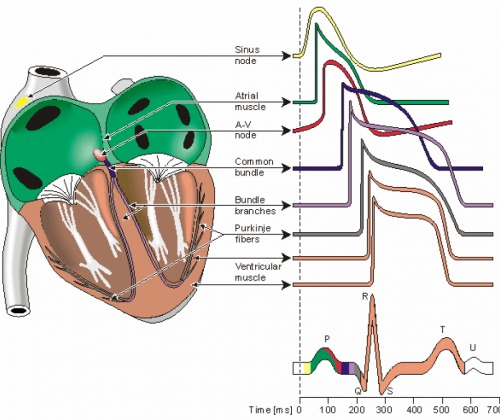

In [20]:
from IPython.display import Image
Image("QRS1.jpeg")

The QRS complex is the combination of three of the graphical deflections seen on a typical electrocardiogram (ECG or EKG). It is usually the central and most visually obvious part of the tracing. It corresponds to the depolarization of the right and left ventricles of the heart and contraction of the large ventricular muscles. [9]
A combination of the Q wave, R wave and S wave, the “QRS complex” represents ventricular depolarization. This term can be confusing, as not all ECG leads contain all three of these waves; yet a “QRS complex” is said to be present regardless.


The QRS detector class for the XQRS algorithm. The XQRS.Conf class is the configuration class that stores initial parameters for the detection. The XQRS.detect method runs the detection algorithm [4], [8].


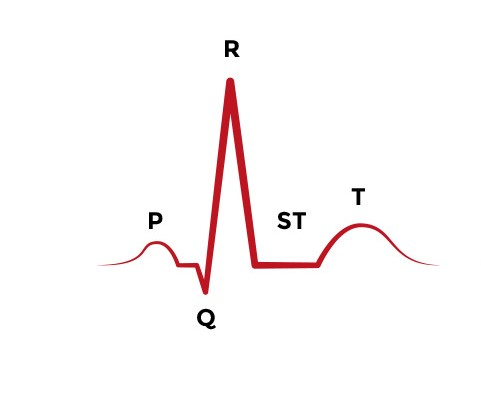

In [21]:
Image("QRS2.jpeg")

In [1]:
#importing packages

import matplotlib.pyplot as plt
import scipy 
from scipy.optimize import curve_fit
from scipy.stats import norm
import wfdb 
import pandas as pd
from wfdb import processing 
import numpy as np
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore', np.RankWarning)

#fonts for titles and labels
font = {'family': 'serif',
        'color':  'orange',
        'weight': 'normal',
        'size': 36,
        }
font2 = {'family': 'serif',
        'color':  'orange',
        'weight': 'normal',
        'size': 24,
        }

### Loading data and compute b(i) <a name="Loading_data_and_compute_b(i)"></a>

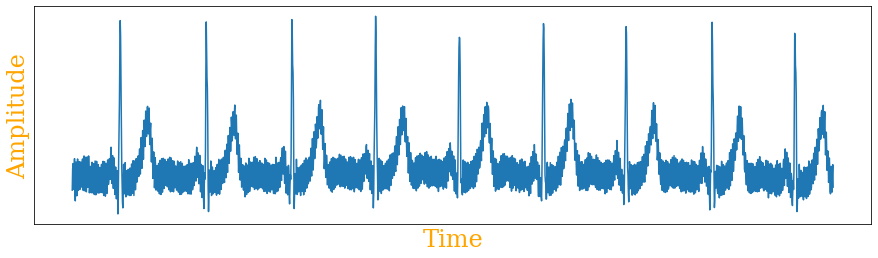

In [29]:
# Declaring Fantasia and MIT data sets

path_fantasia = './1.0.0/'

fantasia = [
                'f1o01', 'f1o02', 'f1o03', 'f1o04', 'f1o05', 'f1o06', 'f1o07', 
                'f1o08', 'f1o09', 'f1o10', 'f1y01', 'f1y02', 'f1y03', 'f1y04', 
                'f1y05', 'f1y06', 'f1y07', 'f1y08', 'f1y09', 'f1y10', 'f2o01', 
                'f2o03', 'f2o04', 'f2o06', 'f2o07', 'f2o08', 'f2o09', 'f2y02', 
                'f2y03', 'f2y04', 'f2y06', 'f2y07'
            ]
#It is just 7 subjects of MIT data sets

path_mit = './mit-1.0.0/'
mit = [
            '16265', '16420', '17052', '16786', '18184', '17453', '19140'
    ]

processing_done = True

# reading Fantasia
if not processing_done:
    rec = []
    data_beats = []
    for subject_id in fantasia:
        rec.append(wfdb.rdrecord(path + subject_id))
        data_beats.append(np.array(rec[-1].p_signal[:, 1]))
        

def compute_beats_interval(data_beats, rec, names):
    all_b = [] # the list of sequential heart interbeat intervals arrays of each subject
    for idx, data in enumerate(data_beats):
        xqrs = processing.XQRS(sig=data, fs=rec[idx].fs)
        fs=rec[idx].fs
        xqrs.detect()
        b = []
        for i in range(len(xqrs.qrs_inds)-1):
            b.append((xqrs.qrs_inds[i+1]-xqrs.qrs_inds[i])/fs)
        b = np.array(b)
        np.save(f'b_{names[idx]}', b)
        all_b.append(b)
    return all_b

if not processing_done:
    names = None # fantasia or mit IDs
    all_b = compute_beats_interval(data_beats, rec, names)
else:
    all_b_fantasia = []
    all_b_mit = []
    for subject_id in fantasia:
        b = np.load(f'b_{subject_id}.npy')
        mu, std = norm.fit(b)
        b[b > mu + 3 * std] = mu
        b[b < mu - 3 * std] = mu
        all_b_fantasia.append(b)
    for subject_id in mit:
        all_b_mit.append(np.load(f'mit0_b_{subject_id}.npy'))

# plot signal
%matplotlib inline
plt.figure(figsize=(15,4))
rec_ = wfdb.rdrecord(path_fantasia + fantasia[9])
sig_ = rec_.p_signal[0:2000, 1]
plt.xlabel('Time', fontdict=font2)
plt.ylabel('Amplitude', fontdict=font2)
plt.xticks([], color='white')
plt.yticks([], color='white')

plt.plot(sig_)
plt.show()


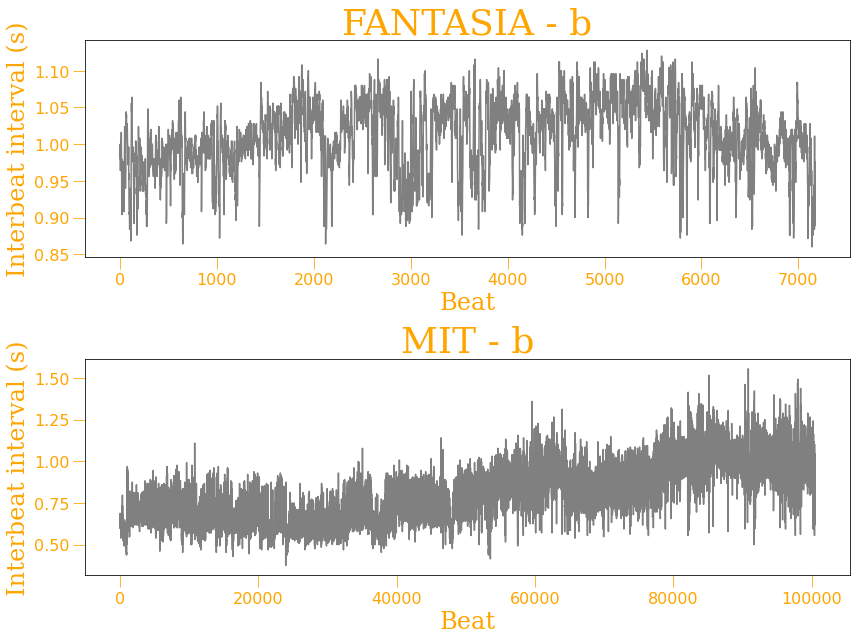

In [3]:
fig, (ax1, ax2) =  plt.subplots(2, 1, figsize=(12, 9))
ax1.plot(all_b_fantasia[0], color='grey')
ax1.set_title('FANTASIA - b', fontdict=font)
ax1.set_xlabel('Beat', fontdict=font2)
ax1.set_ylabel('Interbeat interval (s)', fontdict=font2)

ax2.set_title('MIT - b', fontdict=font)
ax2.plot(all_b_mit[0], color='grey')
ax2.set_xlabel('Beat', fontdict=font2)
ax2.set_ylabel('Interbeat interval (s)', fontdict=font2)
ax1.tick_params(size=12, color='orange', labelsize=16, labelcolor='orange')
ax2.tick_params(size=12, color='orange', labelsize=16, labelcolor='orange')
plt.tight_layout()

### Increments from the polynomial fit <a name="Increments_from_the_polynomial_fit"></a>

The long-term heart rate data analyzed have been
measured as sequential heart interbeat intervals $b(i)$,
where $i$ is the beat number [1]. We investigate the PDF of
heart rate increments at different time scales (in beat
numbers), where the nonstationarity of the data has
been eliminated by local detrending [2].We first integrate
the $b(i)$, $B(m) = \sum_{j=1}^{m} b(j)$, and the resultant $B(m)$ is
divided into sliding segments of size $2s$. Then in each
segment the best $q$th order polynomial is fit to the data.
The differences $\Delta_{s}B(i) = B^{*}(i+s)-B^{*}(i)$ at a scale s
are obtained by sliding in time over the segments, where
$B^{*}(i)$ is a deviation from the polynomial fit. By this
procedure, the $(q-1)$th order polynomial trends are
eliminated and we analyze the whole PDF of $\Delta_{s}B(i)$.

### Fitting polynomial for detrending <a name="Fitting_polynomial_for_detrending"></a>

In [4]:
def get_polyfit(y):
    """ Find the best polynomial to fit a 1D array """
    x = range(0, len(y))
    rms_diff = np.inf
    rms = np.inf
    coeffs = None
    y_fit = None
    deg = 0
    while rms_diff > 10e-5 and deg < max([len(y) - 1, 16]):
        deg += 1
        previous_rms = rms
        previous_coeffs = coeffs
        previous_yfit = y_fit
        # Find the best polynomial fit
        coeffs = np.polyfit(x, y, deg=deg)
        # Evaluate the polynomial
        poly = np.poly1d(coeffs)
        y_fit = poly(x)
        # Find the RMS of the fit
        rms = np.sqrt(np.mean((y - y_fit)**2))
        rms_diff = previous_rms - rms
    return previous_coeffs, np.array(previous_yfit), deg - 1

def compute_B(b):
    return np.cumsum(b)

def segmentation_and_polyfit(B, s):
    i = 0
    segments = [B[i: i + 2 * s] for i in range(0, int(len(B) / (2 * s)))]
    coeffs = []
    polyfit_deviations = [] # B*(i)
    differences_s = []   # delta B* = B*(i + s) - B*(i)
    degs = []
    for segment in segments:
        coeff, segment_fit, deg = get_polyfit(segment)
        coeffs.append(coeff)
        polyfit_deviations = np.concatenate((polyfit_deviations, segment_fit - segment))
        differences_s = [polyfit_deviations[i + s] - polyfit_deviations[i] for i in range(0, len(polyfit_deviations) - s)]
        degs.append(deg)

    return differences_s

### Build the PDF <a name="Build_the_PDF"></a>

In [5]:
def get_pdf(differences_s, scaling=1, bins=50):
    mu, sigma = norm.fit(differences_s)
    histo = np.histogram(differences_s, bins=bins)
    bins = histo[1]
    PDF = scaling * histo[0] / np.sum(histo[0]) # P(delta B*)
    bincenters = [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]
    return bincenters / sigma, PDF, sigma

### Fitting Function <a name="Fitting_Function"></a>

We fit the data to gaussian and the following equation, based on the Castaing's function [3]:

 $$\tilde{P}{s}(x) = \int P_{L}(\frac{x}{\sigma}) {\frac{1}{\sigma }} G_{s,L}(ln \sigma)d(ln\sigma)$$
 
 where $P_{L}$ is the increment PDF at a large scale $L > s$, and the self-similarity kernel $G_{s,L}$ determines the nature of the cascade-type multiplicative process. Here we assume
$P_{L}$ and $G_{s,L}$ are both Gaussian:
 
$$G_{s,L}(ln \sigma) = \frac{1}{\sqrt{2\pi}\lambda}exp(- \frac{ln^2 \sigma}{2\lambda^2}) $$

$$P_{L}(\frac{x}{\sigma})= \frac{1}{\sqrt{2\pi}}exp(- \frac{x^2}{2\sigma^2}) $$

In [6]:
def gaussian(x, mu, sigma):
    """
    Gaussian - probability density function of 1D array
    :param x: 1D array
    :param mu: mean
    :param sigma: standard deviation
    :return: probability density function
    """
    return np.log10(((1 / ( np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)) ** 2)) / 
                    (np.sum((1 / ( np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)) ** 2))))

def Castaing_integral(x, lambd):
    result = scipy.integrate.quad(
       lambda sigma: 1/(2*np.pi*lambd*sigma**2)*np.exp(-(x**2/sigma**2 + np.log(sigma)**2/lambd**2) / 2),
    0, np.inf)
    return result[0]


def log_cast(x,lambd):
        return np.log10(Castaing_integral(x, lambd)/np.sum(Castaing_integral(x, lambd)))

### computing increments for both data sets <a name="computing_increments_for_both_data_sets"></a>

In [7]:
def prepare_differences(all_b, scales=[8, 16, 32, 64, 128, 256, 512, 1024, 2048]):
    differences = []
    fitting_pars = []
    for s in tqdm(range(len(scales))):
        differences.append(np.array([]))
        fitting_pars.append(np.array([]))
        for i, b in enumerate(all_b):
            B = compute_B(b)
            differences_one_subject = segmentation_and_polyfit(B, scales[s])
            mid, pdf, _ = get_pdf(differences_one_subject)
            mid = mid[pdf > 0]
            pdf = pdf[pdf > 0]
            pars, pcov = curve_fit(f=log_cast, xdata=mid, ydata=np.log10(pdf), p0=0.4, bounds=[0.1,1]) 
           
            fitting_pars[s] = np.concatenate((fitting_pars[s], pars))
            differences[s] = np.concatenate((differences[s], differences_one_subject))
            
    return differences, fitting_pars

#differences_fantasia, fitting_pars_fantasia = prepare_differences(all_b_fantasia)
#differences_mit, fitting_pars_mit = prepare_differences(all_b_mit)

# np.save(f'diff_fantasia2', differences_fantasia)
# np.save(f'fp_fantasia2', fitting_pars_fantasia)
# np.save(f'diff_mit', differences_mit)
# np.save(f'fp_mit', fitting_pars_mit)

differences_fantasia = np.load('diff_fantasia2.npy', allow_pickle=True)
fitting_pars_fantasia = np.load('fp_fantasia2.npy', allow_pickle=True)
differences_mit = np.load('diff_mit.npy', allow_pickle=True)
fitting_pars_mit = np.load('fp_mit.npy', allow_pickle=True)

# Gaussian and castaing fit <a name="Gaussian_and_castaing_fit"></a>

In [8]:

%matplotlib inline

clr=['purple','red','orange','gray','lightgreen','green','lightblue','blue', 'lightblue']
scales=[8, 16, 32, 64, 128, 256, 512, 1024, 2048]

fitting_dict = {'cascade': log_cast, 'gaussian': gaussian}

def fit_and_collapse(differences, fit='gaussian'):
    fig, (ax_c, ax) = plt.subplots(2, 1, figsize=(24, 24))
    mid_ = []
    pdf_ = []
    lambd_ = []
    
    for s in range(len(scales)):
        mid, pdf, sigma = get_pdf(differences[s], bins=100)
        # for collapsed plot
        ax.plot(mid, pdf, 'o', markersize=2,color=clr[s % 8])
        # separate plots
        mid = mid[pdf > 0]
        pdf = pdf[pdf > 0]
        if fit == 'cascade':
            pars, pcov = curve_fit(f=fitting_dict[fit], xdata=mid, ydata=np.log10(pdf), p0=0.4, bounds=[0.1,1]) 
            lambd_.append(pars[0])
        elif fit == 'gaussian':
            pars = [0, 1]
            lambd_.append(sigma ** 0.5)
        mid_.append(mid)
        pdf_.append(pdf)
        ax_c.plot(mid, 10**(-s) * pdf, 'o', markersize=5, color=clr[s % 8], label=f's={scales[s]}')
        ax_c.plot(mid, 10**(-s) * (10 ** fitting_dict[fit](mid, *pars)), linewidth=2,
                  color=clr[s%8], alpha=0.5)

    # collapsed plot
    differences = np.array(differences, dtype=object)
    mid, pdf, _ = get_pdf(np.hstack(differences), bins=300)
    pdf = pdf[abs(mid) < 15]
    mid = mid[abs(mid) < 15]
    if fit == 'cascade':
        pars, pcov = curve_fit(f=fitting_dict[fit], xdata=mid, ydata=np.log10(pdf), p0=0.4, bounds=[0.1,0.9])  
    elif fit == 'gaussian': 
        pars = [0, 1]
    ax.plot(mid, 10 ** fitting_dict[fit](mid, *pars), linewidth=5, color='red',alpha=0.5, label=f'{fit}')    

    ax.set_xlabel(r'$\Delta_S B/ \sigma$', fontdict=font)
    ax.set_ylabel(r'$P_S(\Delta_S B)$',  fontdict=font)
    ax_c.set_xlabel(r'$\Delta_S B/ \sigma$', fontdict=font)
    ax_c.set_ylabel(r'$P_S(\Delta_S B)$',  fontdict=font)
    ax.tick_params(size=12, color='orange', labelsize=24, labelcolor='orange')
    ax_c.tick_params(size=12, color='orange', labelsize=24, labelcolor='orange')
    ax.set_title('Collapsed plot', fontdict=font)
    ax.set_yscale('log')
    ax.set_ylim(10e-6, 1)
    ax.legend(fontsize=32)
    ax_c.set_yscale('log')
    ax_c.legend(fontsize=32)
    ax_c.set_ylim(10e-14, 1)
    ax.grid()
    ax_c.grid()
    plt.show()
    lambd_ = np.array(lambd_)
#     plt.plot(scales, lambd_ ** 2)
#     plt.xscale('log')
#     plt.show()
    return mid_, pdf_, lambd_

### Fantasia Dataset Plots <a name="Fantasia_Dataset_Plots"></a>

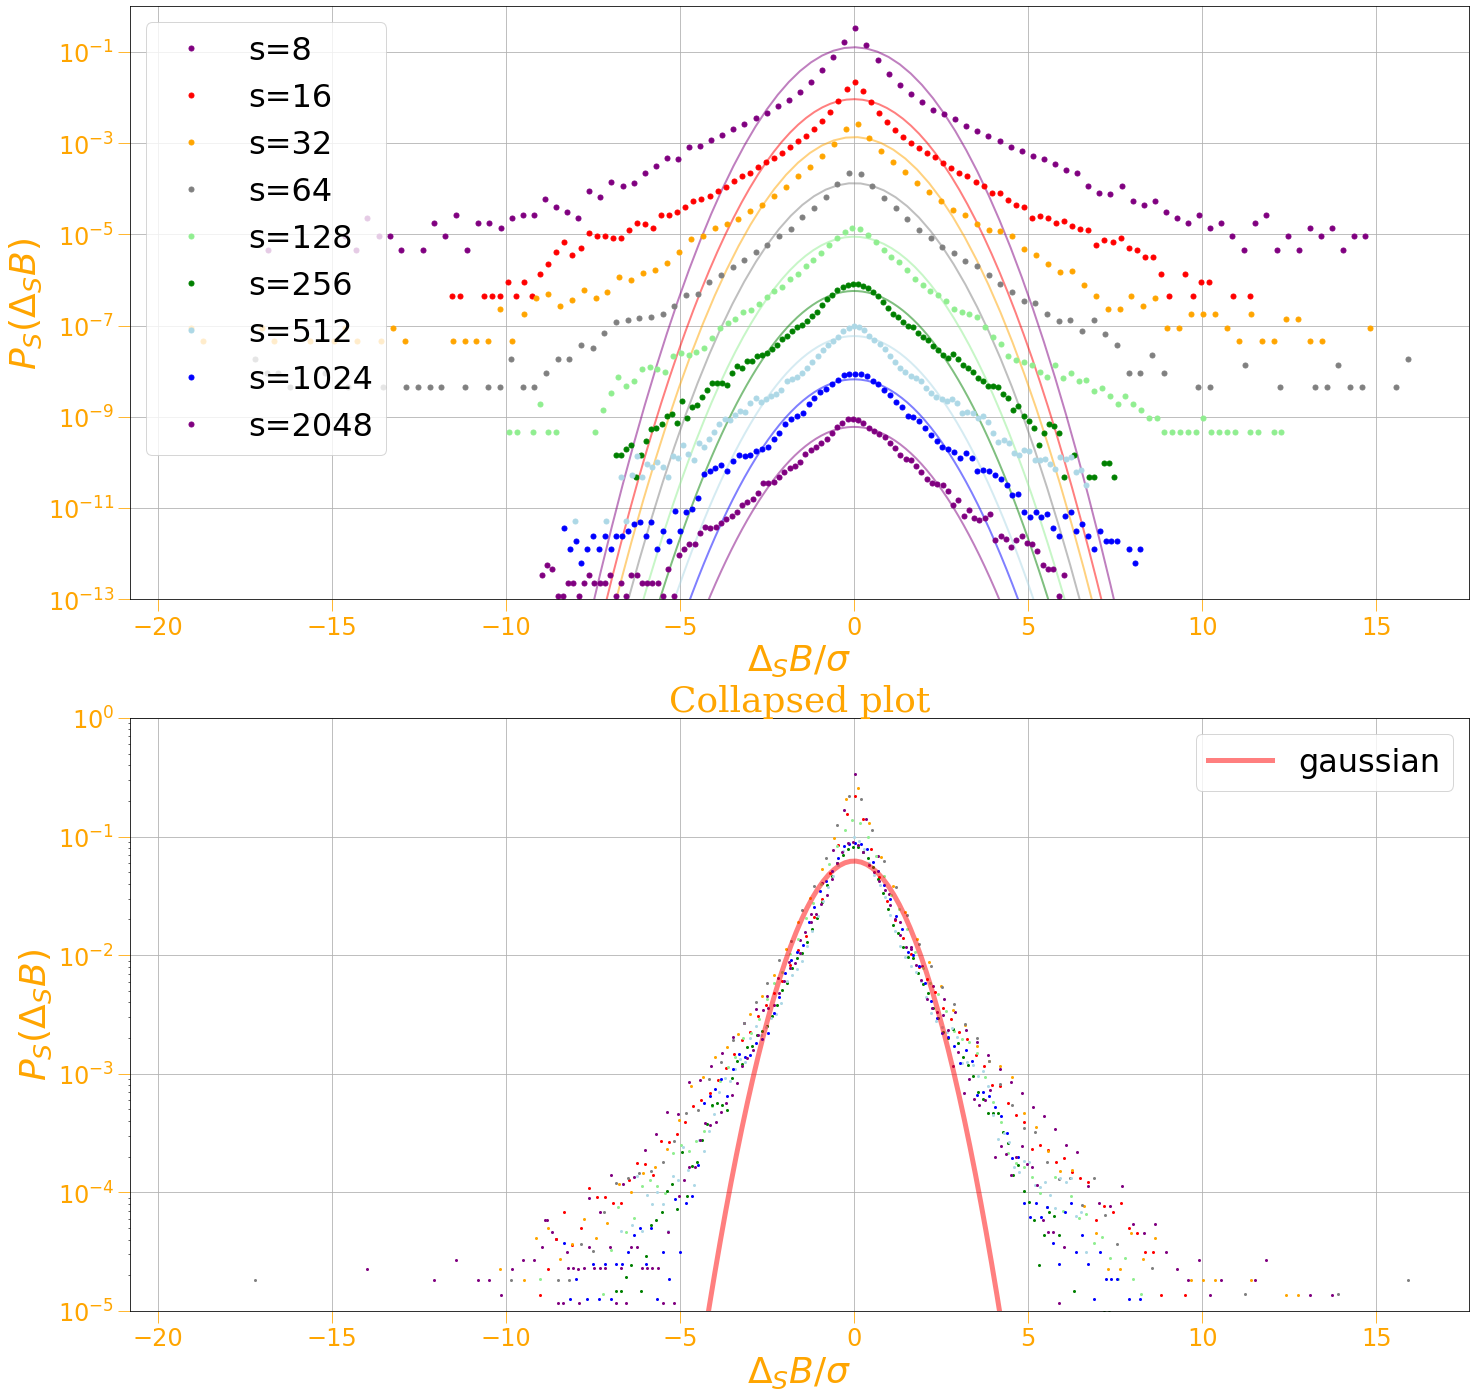

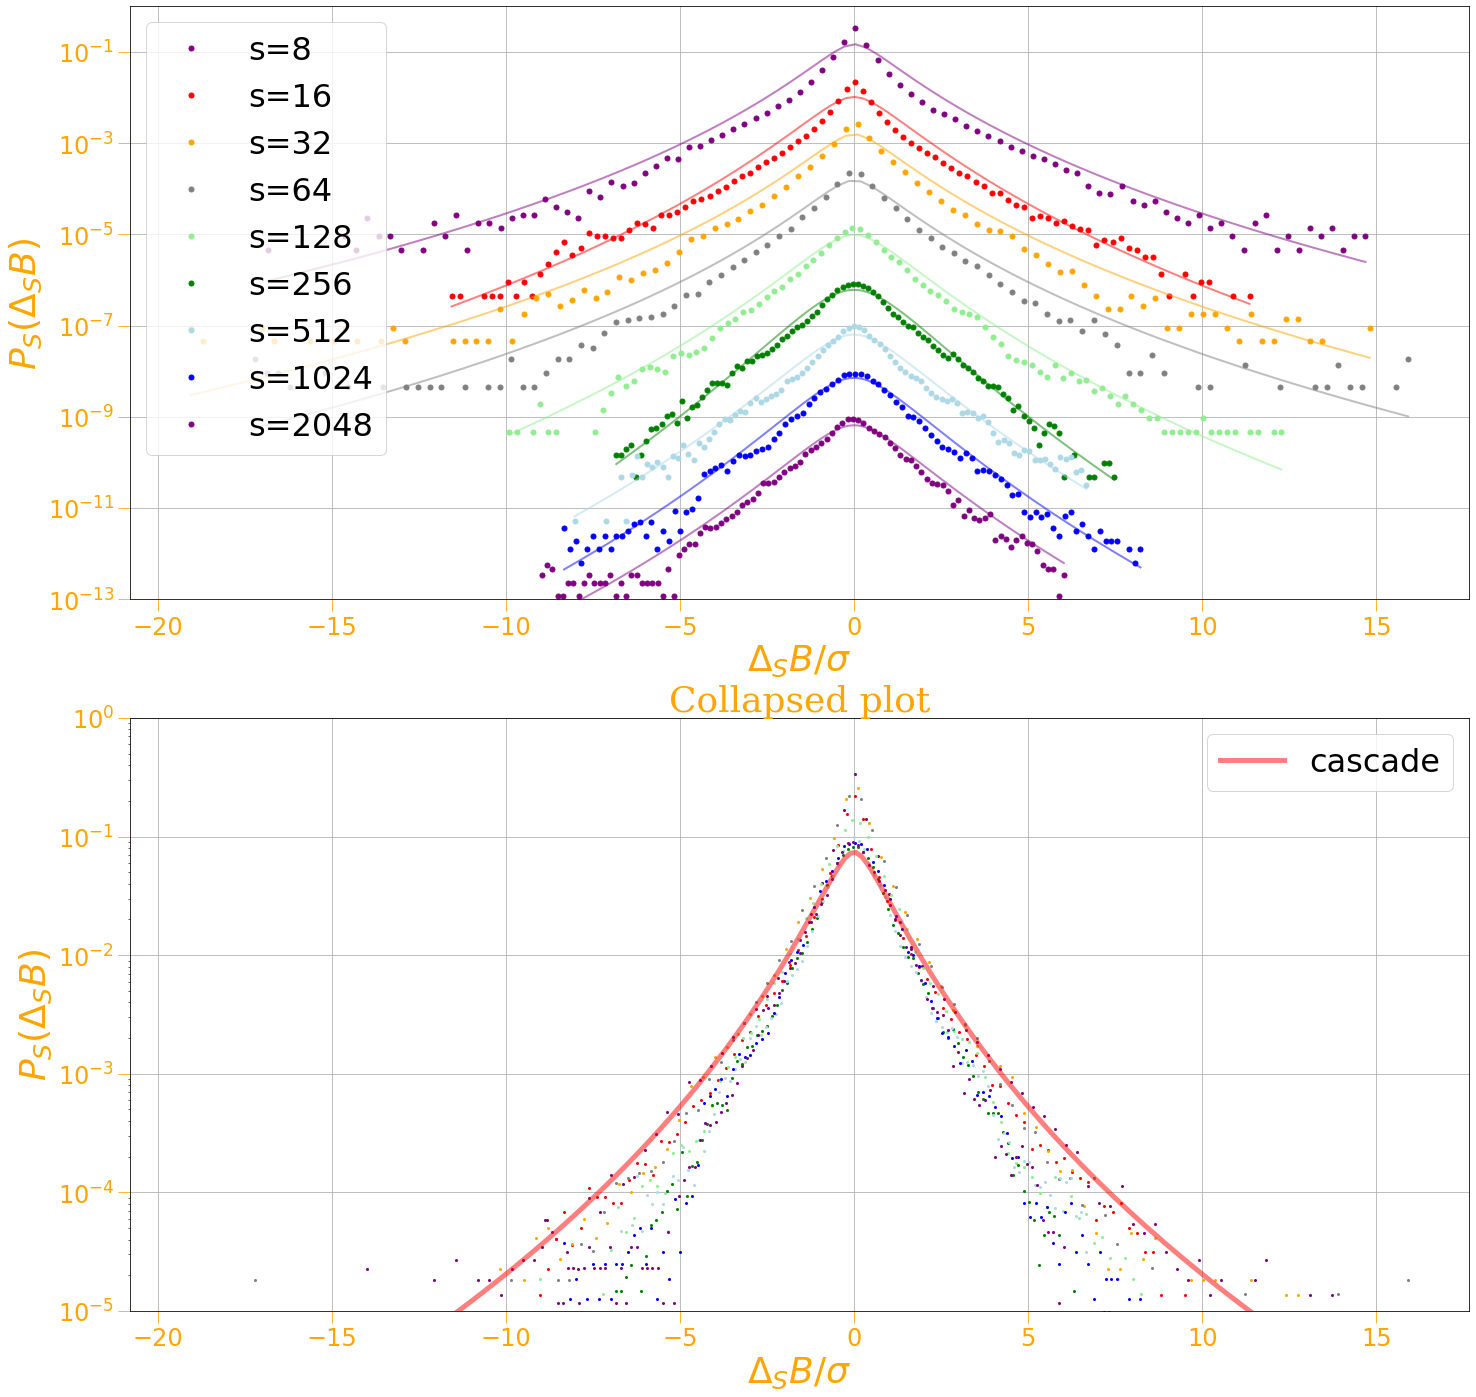

In [9]:
_, _, _ = fit_and_collapse(differences_fantasia, fit='gaussian')
mid_fantasia, pdf_fantasia, lambd_fantasia = fit_and_collapse(differences_fantasia, fit='cascade')

### MIT Dataset (daily routine) Plots <a name="MIT_Dataset_(daily_routine)_Plots"></a>

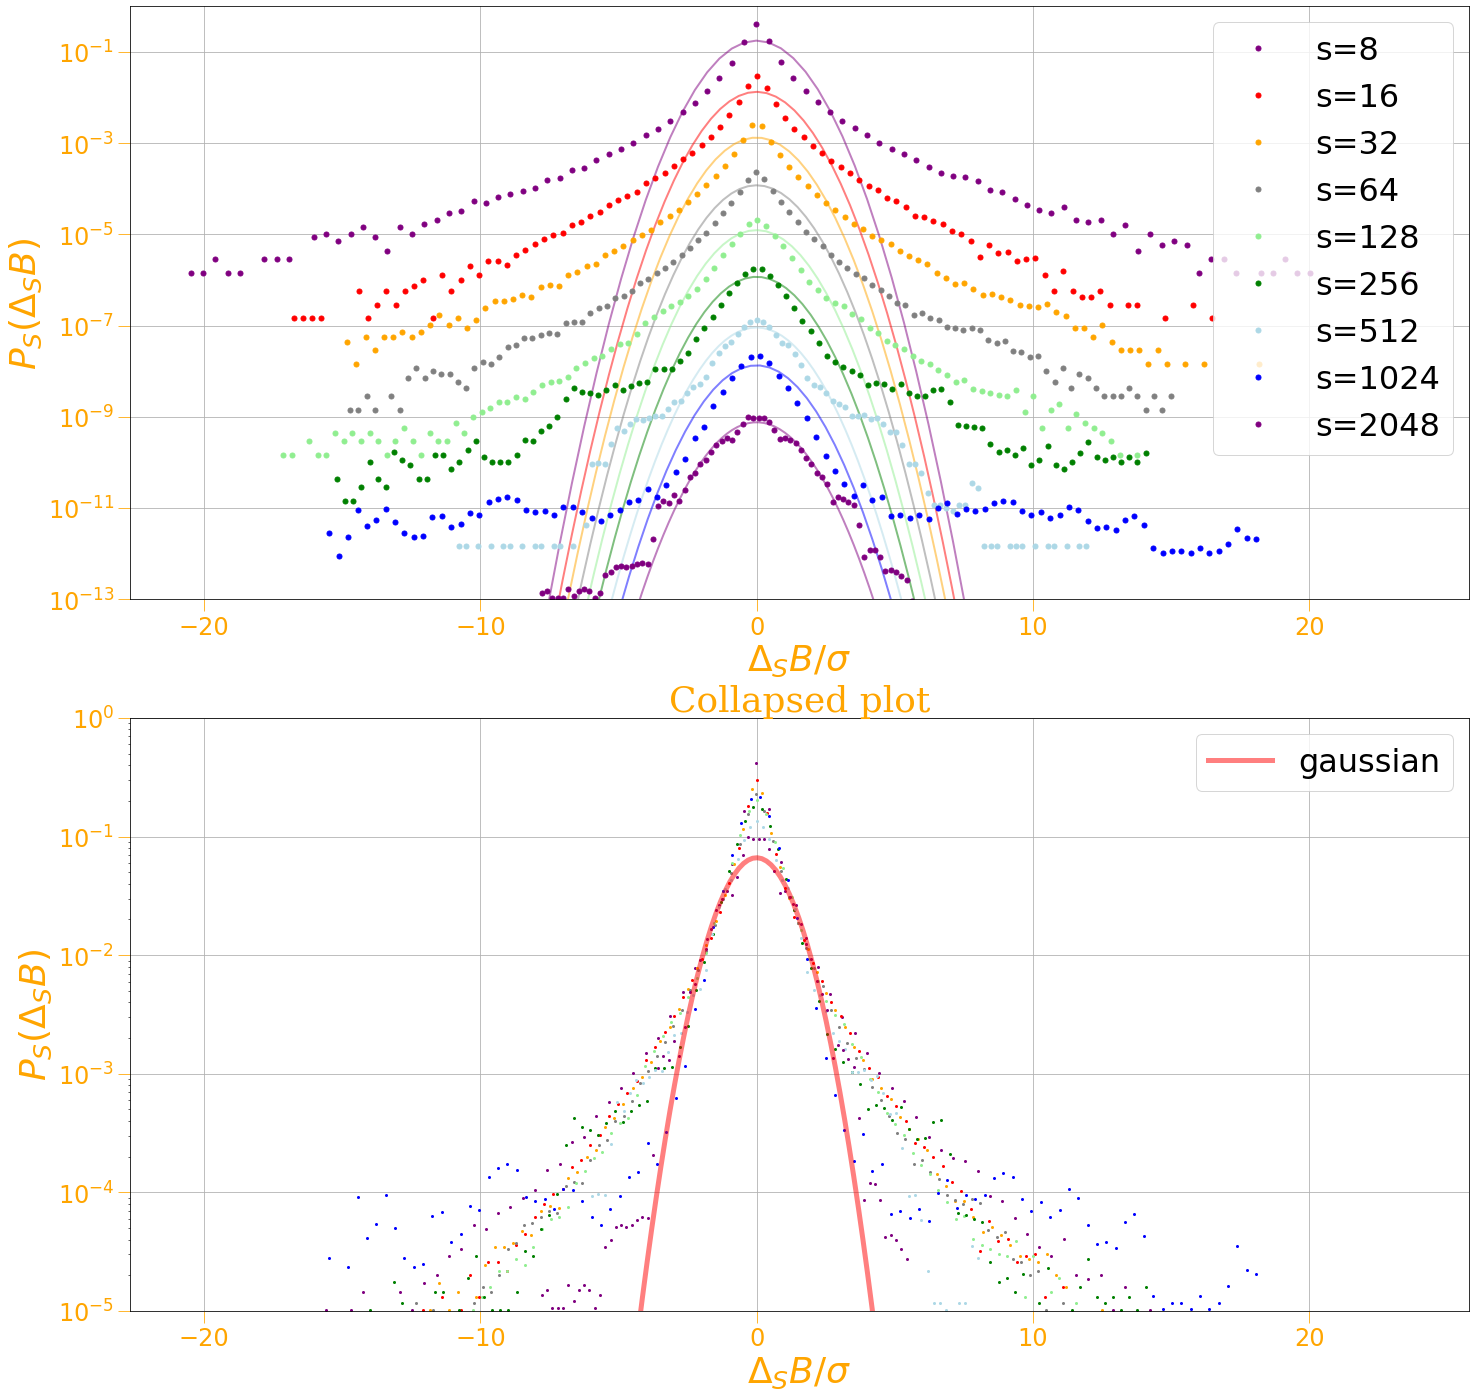

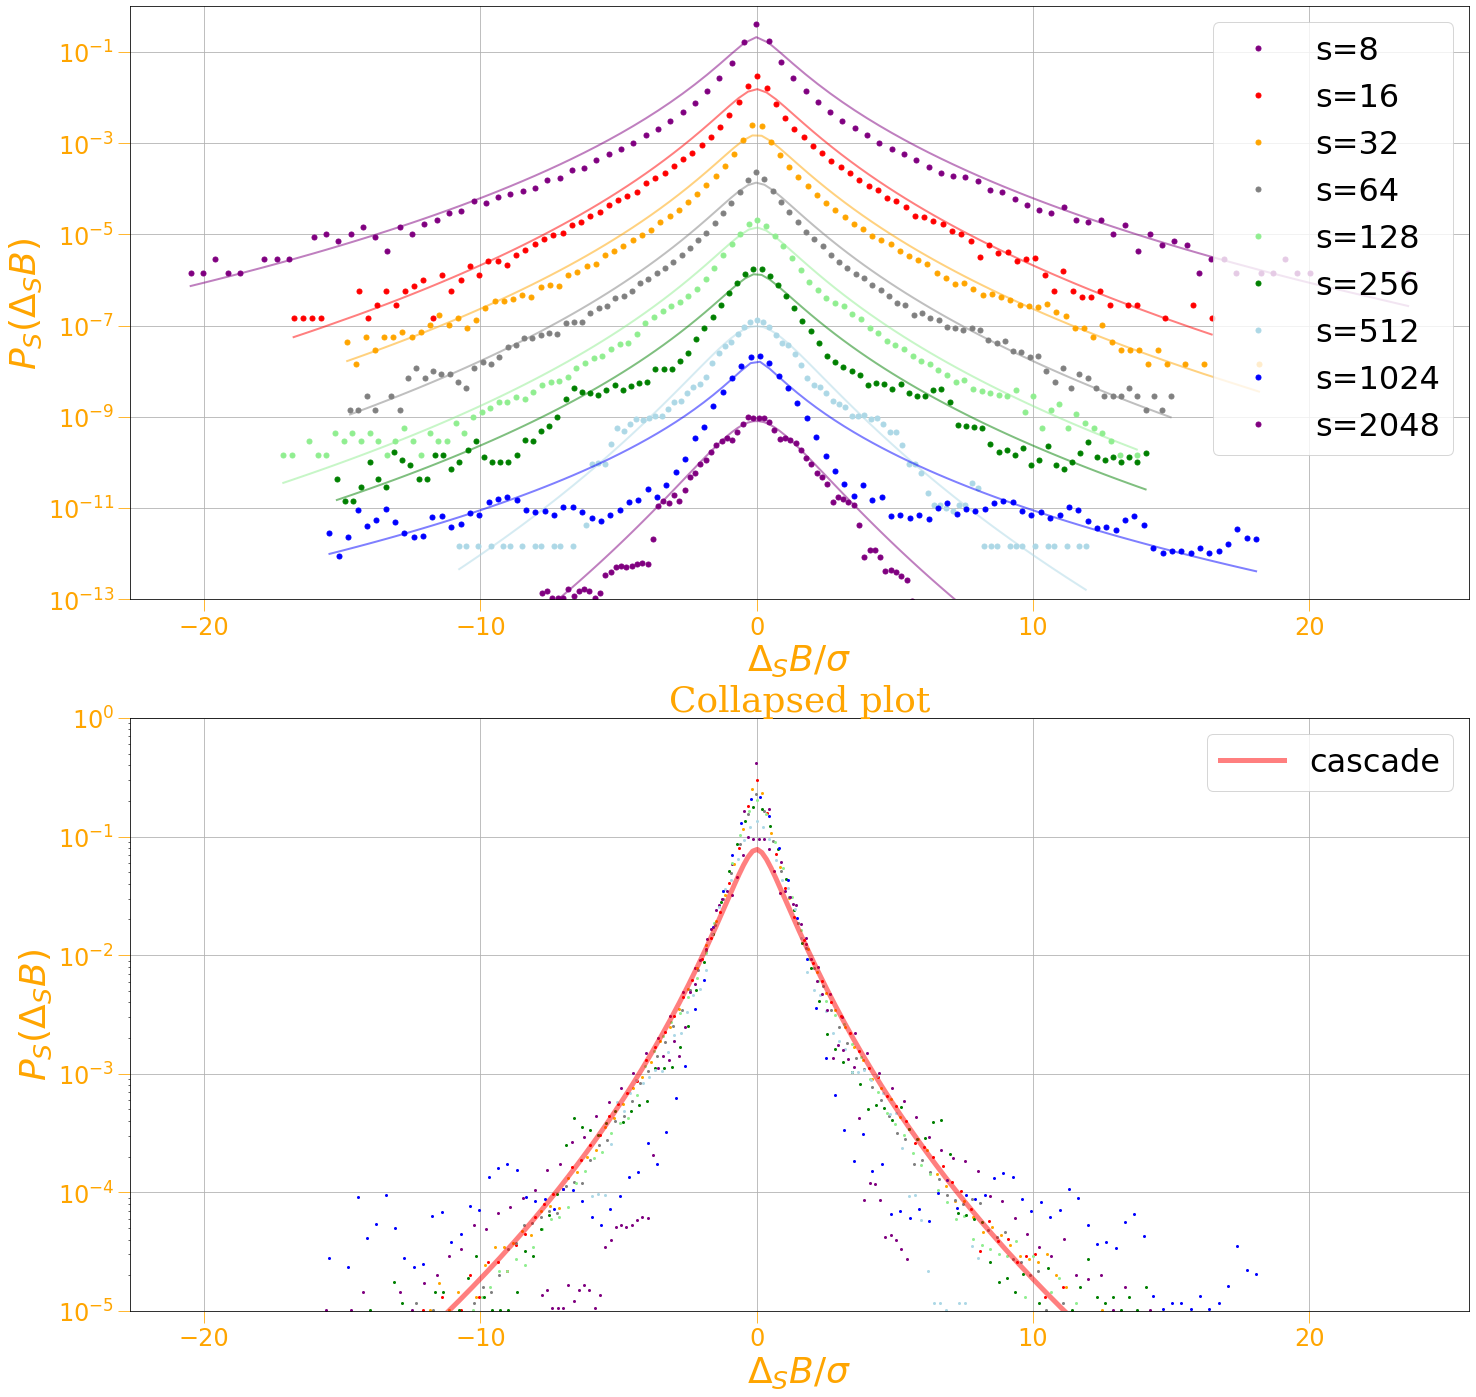

In [10]:
%matplotlib inline
_, _, _ = fit_and_collapse(differences_mit, fit='gaussian')
mid_mit, pdf_mit, lambd_mit = fit_and_collapse(differences_mit, fit='cascade')

### Plots of the Fitting Parameters <a name="Plots_of_the_Fitting_Parameters"></a>

First, we define the function that computes the mean and the standard deviation of the group for each scaling factor $s$. We compute these statistics ($\mu_S$, $\sigma_S$) for each dataset.

In [11]:
def stats_fitting_pars(fitting_pars):
    """
        fitting_pars - the fitting parameters already computed for Fantasia or MIT datasets
    """
    mu_pars = []
    std_pars = []
    for s in range(len(fitting_pars)):
        mu, std = norm.fit(fitting_pars[s] ** 2)
        mu_pars.append(mu)
        std_pars.append(std)
    return mu_pars, std_pars

mu_pars_fantasia, std_pars_fantasia = stats_fitting_pars(fitting_pars_fantasia)
mu_pars_mit, std_pars_mit = stats_fitting_pars(fitting_pars_mit)

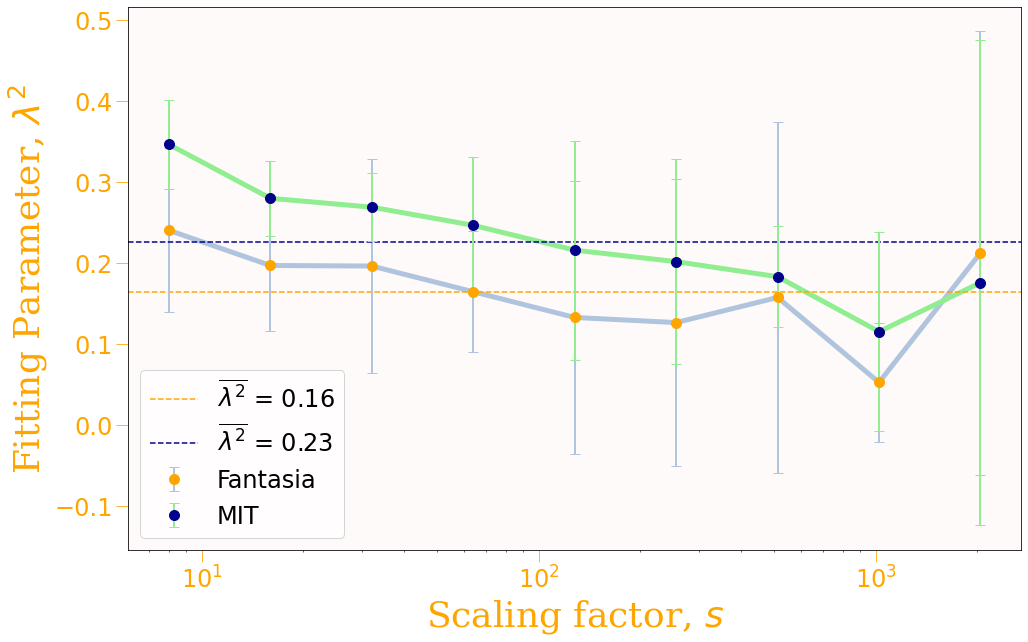

In [12]:
def horizontal_line_fit(x, a):
    return a

# FANTSIA
popt, pcov = curve_fit(horizontal_line_fit, scales, mu_pars_fantasia, p0=[0.25])
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(scales, mu_pars_fantasia, zorder=1, color='lightsteelblue', linewidth=5)
ax.axhline(y=popt[0], linestyle='--', color='orange', label=r'$\overline{\lambda^2}$ = ' + (str(round(popt[0], 2))))
ax.errorbar(scales, mu_pars_fantasia, yerr = std_pars_fantasia, label=r'Fantasia', zorder=2, fmt='o', color='orange',
             ecolor='lightsteelblue', capsize=5, elinewidth=2, markersize=10)
# MIT
popt, pcov = curve_fit(horizontal_line_fit, scales, mu_pars_mit, p0=[0.25])
ax.plot(scales, mu_pars_mit, zorder=1, color='lightgreen', linewidth=5)
ax.axhline(y=popt[0], linestyle='--', color='darkblue', label=r'$\overline{\lambda^2}$ = ' + (str(round(popt[0], 2))))
ax.errorbar(scales, mu_pars_mit, yerr = std_pars_mit, label=r'MIT', zorder=2, fmt='o', color='darkblue',
             ecolor='lightgreen', capsize=5, elinewidth=2, markersize=10)

ax.set_xlabel(r'Scaling factor, $s$', fontdict=font)
ax.set_ylabel(r'Fitting Parameter, $\lambda^2$', fontdict=font)
ax.set_xscale('log')
ax.set_facecolor('snow')
ax.tick_params(size=12, color='orange', labelsize=24, labelcolor='orange')
plt.legend(fontsize = 24)
plt.show()

### Conclusions <a name="Conclusions"></a>

by doing these assingments:
<ol>
<li> build the cumulative time series B(i) from the detrended and normalised heart beat time series b(i)
<li> do a polynomial fit of B(i)
<li> calculate the increments (fluctuation) from the polynomial fit
<li> build the increments PDF and fit it with Gaussian and non Gaussian distributions.
<li> test the scale invariance of the PDFs by collapse plot
</ol>
    we conclude that:
<ul>
<li> when the PDF’s at different scales are superimposed all the data collapse on the same curve, which is one of the characteristic features observed in fluctuations at a critical point
<li> In addition, the slopes of $\lambda^2$ vs logs are much closer to zero, which means the absence of cascade steps across the scales in the corresponding range.

 </ul>

In [1]:
from matplotlib.animation import FuncAnimation
from random import randint
%matplotlib notebook
x = []
y = []
fig, (ax, ax_2) = plt.subplots(2, 1, figsize=(9, 6))
lambd_ = lambd_fantasia
mid_ = mid_fantasia
pdf_ = pdf_fantasia
# function that draws each frame of the animation
def animate(i):
    ax.clear()
    ax_2.clear()
    ax.grid()
    ax.set_yscale('log')
    ax.set_xlabel(r'$\Delta_S B/ \sigma$', fontdict=font2)
    ax.set_ylabel(r'$P_S(\Delta_S B)$',  fontdict=font2)
    ax_2.set_facecolor('snow')
    ax_2.yaxis.set_ticks([0.35, 0.30, 0.25, 0.20, 0.15])
    ax_2.xaxis.set_ticks([10, 100, 1000])
    ax_2.set_ylim([0.1, 0.4])
    ax_2.set_xlim([7, 2200])
    ax_2.set_xlabel(r'Scaling $s$', fontdict=font2)
    ax_2.set_ylabel(r'Fitting parameter $\lambda^2$',  fontdict=font2)
    ax.tick_params(size=12, color='orange', labelsize=16, labelcolor='orange')
    ax_2.tick_params(size=12, color='orange', labelsize=16, labelcolor='orange')
    ax_2.set_xscale('log')
    for s in range(i):
        ax.plot(mid_[s], 10**(-s) * Castaing_integral(mid_[s], lambd_[s]) / 
                np.sum(Castaing_integral(mid_[s], lambd_[s])) , linewidth=4,
                color=clr[s % 8], alpha=0.25)
    if i < 9:
        ax.plot(mid_[i], 10**(-i) * pdf_[i], 'o', markersize=2, color=clr[i % 8], label=f's={scales[i]}')
        ax.plot(mid_[i], 10**(-i) * Castaing_integral(mid_[i], lambd_[i]) / 
                    np.sum(Castaing_integral(mid_[i], lambd_[i])) , linewidth=5,
                    color=clr[i % 8], alpha=0.5)
        ax.text(8, 0.01, f's = {scales[i]}', fontdict=font)
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax_2.plot(scales[0:i+1], lambd_[0:i+1] ** 2, linewidth=2.5, color='orange')
    ax_2.plot(scales[0:i+1], lambd_[0:i+1] ** 2, 'o', markersize=8, color='black')
    plt.tight_layout()
# run the animation
ani = FuncAnimation(fig, animate, frames=10, interval=250, repeat=True)

plt.show()

NameError: name 'plt' is not defined

### Bibliography <a name="Bibliography"></a>

[1] Ken Kiyono, Zbigniew R. Struzik, Naoko Aoyagi, Seiichiro Sakata, Junichiro Hayano, and Yoshiharu Yamamoto. Critical Scale Invariance in a Healthy Human Heart Rate. Phys. Rev. Lett. 93, 178103 – Published 20 October 2004 <br>
[2] C. K. Peng et al., Phys. Rev. Lett. 70, 1343 (1993). <br>
[3] B. Castaing, Y. Gagne, and E. J. Hopfinger, Physica (Amsterdam) 46D, 177 (1990). <br>
[4] https://wfdb.readthedocs.io/en/latest/wfdb.html <br>
[5] Iyengar N, Peng C-K, Morin R, Goldberger AL, Lipsitz LA. Age-related alterations in the fractal scaling of cardiac interbeat interval dynamics. Am J Physiol 1996;271:1078-1084. https://physionet.org/content/fantasia/1.0.0/ <br>
[6] Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220. https://physionet.org/content/nsrdb/1.0.0/ <br>
[7] A Neurovisceral Integration Model of Heart Rate Variability. J.F. Thayer, in Reference Module in Neuroscience and Biobehavioral Psychology, 2017. <br>
[8] https://www.aclsmedicaltraining.com/rhythm-recognition/ <br>
[9] https://www.kubios.com/hrv-time-series/

# Thanks for your attention 